In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import math

In [2]:
requests = pd.read_csv("/home/ec2-user/data/311_service_requests.csv")
venues = pd.read_csv("/home/ec2-user/data/food_venues.csv", encoding='latin1')
demographics = pd.read_csv("/home/ec2-user/data/demographics.csv")
demographics_city = pd.read_csv("/home/ec2-user/data/demographics_city.csv")
health = pd.read_csv("/home/ec2-user/data/community_health.csv")
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
nyc_lat = nyc.to_crs({'init': 'epsg:4326'})

/home/ec2-user/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = requests.copy().dropna(subset=["latitude", "longitude"])
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
geo_requests = gpd.GeoDataFrame(df, crs=4326, geometry=geometry)

In [4]:
geographic = pd.read_csv("/home/ec2-user/data/geographic.csv")
geographic_shapes = pd.DataFrame(data=geographic.columns, columns=["nta_code"])
shapes = []
for code in geographic.columns:
    coordinates = geographic[code]
    longitude = [x for i, x in enumerate(coordinates) if i % 2 == 0 and not math.isnan(x)]
    latitude = [x for i, x in enumerate(coordinates) if i % 2 == 1 and not math.isnan(x)]
    geometry = list(zip(longitude, latitude))
    polygon = Polygon(geometry)
    shapes.append(polygon)
geographic_shaped = gpd.GeoDataFrame(geographic_shapes, crs=4326, geometry=shapes)
nta = geographic_shaped.copy().merge(demographics_city[["nta_code", "nta_name", "population"]], on = "nta_code")

In [93]:
# fig, ax = plt.subplots()
# plt.axis("off")
# fig.set_size_inches(20,30)
# ax.set_facecolor('grey')
# ax.grid(False)
# ax.set_aspect('equal')
#nta.plot(ax=ax, edgecolor='black')
#nyc_lat.plot(ax=ax, edgecolor='black')
#geo_requests.head(100000).plot(ax=ax, marker='o', color='red', markersize=5)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


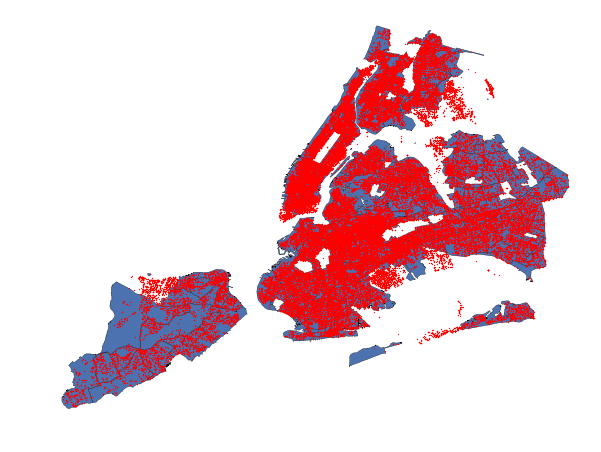

In [184]:
fig, ax = plt.subplots()
plt.axis("off")
fig.set_size_inches(10,15)
ax.set_facecolor('grey')
ax.grid(False)
ax.set_aspect('equal')
nta.plot(ax=ax, edgecolor='black')
geo_requests.head(100000).plot(ax=ax, marker='o', color='red', markersize=1)

In [7]:
key_map = pd.read_csv("/home/ec2-user/data/requests_labeled.csv")
all_requests = requests[["unique_key", "created_date", "closed_date", "complaint_type", "resolution_date", "due_date"]].merge(key_map, on="unique_key", how="left")

In [8]:
counts = all_requests.groupby("nta_code").count()

In [61]:
pointInPoly = gpd.sjoin(geo_requests[["geometry", "unique_key", "complaint_type"]], nta, how='inner') 
counts = pointInPoly.groupby("nta_code").count()

In [9]:
nta_requests = counts.reset_index()[["nta_code", "unique_key"]].merge(nta, on="nta_code")
nta_requests = gpd.GeoDataFrame(nta_requests, crs=4326, geometry=nta_requests["geometry"])

In [10]:
nta_requests["calls_fraction"] = nta_requests["unique_key"] / nta_requests["population"]

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


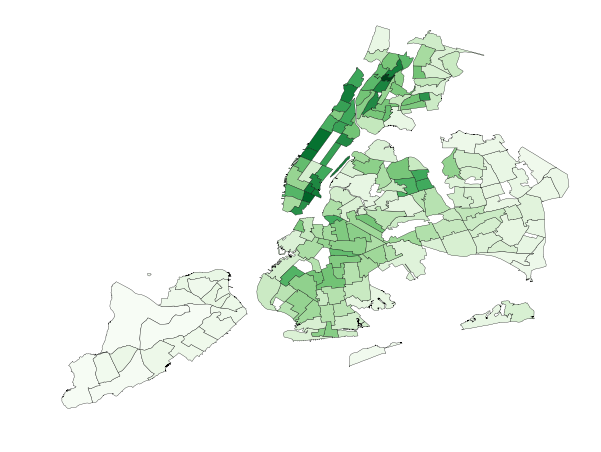

In [20]:
fig, ax = plt.subplots()
plt.axis("off")
fig.set_size_inches(10,15)
ax.set_facecolor('grey')
ax.grid(False)
ax.set_aspect('equal')
nta_with_demographics.plot(ax=ax, edgecolor='black', column='median_age', cmap='Greens')

In [12]:
nta_with_demographics = nta_requests.merge(demographics_city, on="nta_code")
nta_with_demographics.head(10)

,nta_code,unique_key,geometry,nta_name_x,population_x,calls_fraction,nta_name_y,borough,population_y,under_5_years,...,15000_to_24999,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income
0,BK09,3260,"POLYGON ((-73.9923651125165 40.6896983761262, ...",Brooklyn Heights-Cobble Hill,22887,0.142439,Brooklyn Heights-Cobble Hill,Brooklyn,22887,1300,...,657,606,760,1225,1187,1791,1173,2776,105398,169555
1,BK17,12368,"POLYGON ((-73.918093977571 40.5865785696998, -...",Sheepshead Bay-Gerritsen Beach-Manhattan Beach,64518,0.191698,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,Brooklyn,64518,3276,...,2822,2486,2823,3967,2869,3735,1151,1369,51314,71041
2,BK19,5937,"POLYGON ((-73.96035096217979 40.5873145189372,...",Brighton Beach,35547,0.167018,Brighton Beach,Brooklyn,35547,1780,...,1585,1509,1263,1728,1114,1228,614,665,30872,59875
3,BK21,4226,"POLYGON ((-73.97459143645879 40.5831470533106,...",Seagate-Coney Island,31965,0.132207,Seagate-Coney Island,Brooklyn,31965,1926,...,1711,900,1197,1346,593,617,300,193,23229,43234
4,BK23,910,"POLYGON ((-73.96889138711559 40.5752694696932,...",West Brighton,17750,0.051268,West Brighton,Brooklyn,17750,506,...,1187,539,1142,1257,629,810,409,111,38047,53608
5,BK25,7361,"POLYGON ((-73.95859421211109 40.6104112689022,...",Homecrest,44316,0.166103,Homecrest,Brooklyn,44316,3474,...,1832,1543,2185,2551,1611,1965,648,661,47882,69431
6,BK26,4443,"POLYGON ((-73.9651452800145 40.5911101495602, ...",Gravesend,29436,0.150938,Gravesend,Brooklyn,29436,1703,...,1631,1278,1453,1931,825,978,318,193,35550,53344
7,BK27,5179,"POLYGON ((-74.0020053868385 40.5941406050305, ...",Bath Beach,29931,0.173031,Bath Beach,Brooklyn,29931,1766,...,1091,932,1407,2016,1176,1606,711,521,55193,76037
8,BK28,11516,"POLYGON ((-73.97963965192659 40.6155727854739,...",Bensonhurst West,88727,0.129791,Bensonhurst West,Brooklyn,88727,5104,...,3878,3132,4323,5362,3281,3496,1221,824,46137,63192
9,BK29,8161,"POLYGON ((-73.9747780122118 40.6126467127678, ...",Bensonhurst East,62978,0.129585,Bensonhurst East,Brooklyn,62978,3578,...,2787,2409,3075,3870,2451,2379,887,636,45108,63848


In [89]:
pointInPoly[["unique_key", "nta_code"]].reset_index()[["unique_key", "nta_code"]].to_csv("/home/ec2-user/data/requests_labeled.csv", index=False)

In [90]:
pointInPoly[["unique_key", "nta_code"]].reset_index()[["unique_key", "nta_code"]].head(10)

,unique_key,nta_code
0,28272192,BK32
1,28272411,BK32
2,28274189,BK32
3,28275557,BK32
4,28281747,BK32
5,28289116,BK32
6,28289334,BK32
7,28290193,BK32
8,28290205,BK32
9,28291664,BK32


In [95]:
population = pd.read_csv("/home/ec2-user/data/demo_data/pop_nta.csv")

In [101]:
population["nta_code"] = population["NTA Code"]

In [121]:
nta_with_demographics.columns

Index(['nta_code', 'unique_key', 'geometry', 'nta_name_x', 'population_x',
       'calls_fraction', 'nta_name_y', 'borough', 'population_y',
       'under_5_years', '5-9_years', '10-14_years', '15-19_years',
       '20-24_years', '25-29_years', '30-34_years', '35-39_years',
       '40-44_years', '45-49_years', '50-54_years', '55-59_years',
       '60-64_years', 'over_65_years', 'median_age', 'people_per_acre',
       'households', 'less_than_10,000', '10000_to_14999', '15000_to_24999',
       '25000_to_34999', '35000_to_49999', '50000_to_74999', '75000_to_99999',
       '100000_to_149999', '150000_to_199999', '200000_or_more',
       'median_income', 'mean_income'],
      dtype='object')

In [122]:
nta_with_demographics.mean_income

0      169555
1       71041
2       59875
3       43234
4       53608
5       69431
6       53344
7       76037
8       63192
9       63848
10      73763
11      82209
12      61435
13     124522
14      47759
15      54363
16     145160
17     123292
18     102796
19      60412
20      60833
21      72030
22      73705
23      91019
24      76465
25      78602
26      56848
27      51519
28      54671
29     106989
        ...  
147     70107
148     73655
149     80029
150     79705
151     53129
152     68064
153     66068
154     93025
155     46685
156     70094
157     66384
158     75776
159     72664
160    109187
161     95129
162     96344
163     70606
164    108550
165     68588
166     81634
167     64533
168    109101
169     95325
170    105312
171     93554
172     78983
173     74260
174     92008
175    101627
176    101538
Name: mean_income, Length: 177, dtype: int64

In [123]:
nta_with_demographics.calls_fraction

0      0.142439
1      0.191698
2      0.167018
3      0.132207
4      0.051268
5      0.166103
6      0.150938
7      0.173031
8      0.129791
9      0.129585
10     0.150829
11     0.173610
12     0.172166
13     0.240059
14     0.105253
15     0.241071
16     0.265961
17     0.275605
18     0.163903
19     0.132227
20     0.129239
21     0.161825
22     0.169360
23     0.206894
24     0.220454
25     0.160959
26     0.149839
27     0.216460
28     0.150038
29     0.275732
         ...   
147    0.212585
148    0.208993
149    0.254023
150    0.164490
151    0.242954
152    0.164856
153    0.150136
154    0.238662
155    0.209136
156    0.156714
157    0.130006
158    0.174906
159    0.244487
160    0.233994
161    0.204561
162    0.267322
163    0.165494
164    0.254622
165    0.000032
166    0.205672
167    0.258889
168    0.256235
169    0.213207
170    0.214902
171    0.277832
172    0.238575
173    0.291158
174    0.281193
175    0.171250
176    0.226817
Name: calls_fraction, Le

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


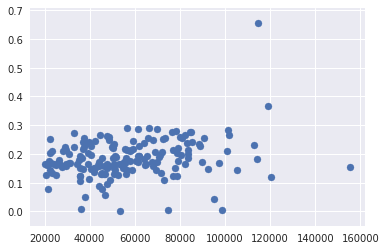

In [128]:
plt.scatter(nta_with_demographics.median_income, nta_with_demographics.calls_fraction, )

In [130]:
nta_with_demographics.columns

Index(['nta_code', 'unique_key', 'geometry', 'nta_name_x', 'population_x',
       'calls_fraction', 'nta_name_y', 'borough', 'population_y',
       'under_5_years', '5-9_years', '10-14_years', '15-19_years',
       '20-24_years', '25-29_years', '30-34_years', '35-39_years',
       '40-44_years', '45-49_years', '50-54_years', '55-59_years',
       '60-64_years', 'over_65_years', 'median_age', 'people_per_acre',
       'households', 'less_than_10,000', '10000_to_14999', '15000_to_24999',
       '25000_to_34999', '35000_to_49999', '50000_to_74999', '75000_to_99999',
       '100000_to_149999', '150000_to_199999', '200000_or_more',
       'median_income', 'mean_income'],
      dtype='object')

In [137]:
geo_requests.merge(requests[["unique_key", "created_date", "closed_date", "complaint_type", "resolution_date", "due_date"]], on="unique_key", how = "left")

,unique_key,created_date_x,closed_date_x,agency_acronym,agency_name,complaint_type_x,descriptor,location_type,incident_zip,incident_address,...,community_board,borough,latitude,longitude,geometry,created_date_y,closed_date_y,complaint_type_y,resolution_date_y,due_date_y
0,28272192,06/16/2014 09:34:00 AM,06/16/2014 12:00:00 PM,DSNY,BCC - Brooklyn South,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11232,218 31 STREET,...,07 BROOKLYN,BROOKLYN,40.656066,-73.999805,POINT (-73.99980537979999 40.6560662597),06/16/2014 09:34:00 AM,06/16/2014 12:00:00 PM,Sanitation Condition,06/16/2014 12:00:00 PM,NaN
1,28272281,06/16/2014 08:21:00 AM,06/16/2014 12:00:00 PM,DSNY,BCC - Brooklyn South,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11234,5207 AVENUE T,...,18 BROOKLYN,BROOKLYN,40.611781,-73.923889,POINT (-73.92388916029999 40.6117813595),06/16/2014 08:21:00 AM,06/16/2014 12:00:00 PM,Sanitation Condition,06/16/2014 12:00:00 PM,NaN
2,28272228,06/16/2014 12:00:00 AM,07/15/2014 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,1-2 Family Dwelling,11209,230 94 STREET,...,10 BROOKLYN,BROOKLYN,40.618345,-74.034990,POINT (-74.03499021970001 40.61834482),06/16/2014 12:00:00 AM,07/15/2014 12:00:00 AM,Rodent,07/15/2014 12:00:00 AM,07/16/2014 12:13:55 PM
3,28272229,06/16/2014 12:00:00 AM,07/01/2014 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11215,NaN,...,06 BROOKLYN,BROOKLYN,40.662800,-73.978348,POINT (-73.97834812409999 40.6627999121),06/16/2014 12:00:00 AM,07/01/2014 12:00:00 AM,Rodent,07/01/2014 12:00:00 AM,07/16/2014 02:30:53 PM
4,28272230,06/16/2014 12:00:00 AM,04/28/2014 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Commercial Building,10002,174 ORCHARD STREET,...,03 MANHATTAN,MANHATTAN,40.721688,-73.988391,POINT (-73.98839066079999 40.7216876367),06/16/2014 12:00:00 AM,04/28/2014 12:00:00 AM,Rodent,04/28/2014 12:00:00 AM,07/16/2014 11:05:03 PM
5,28272232,06/16/2014 06:59:00 AM,06/18/2014 12:00:00 PM,DSNY,BCC - Brooklyn North,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11221,WOODBINE STREET,...,04 BROOKLYN,BROOKLYN,40.690767,-73.918473,POINT (-73.91847300560001 40.6907670242),06/16/2014 06:59:00 AM,06/18/2014 12:00:00 PM,Sanitation Condition,06/18/2014 12:00:00 PM,NaN
6,28272233,06/16/2014 10:31:00 AM,06/20/2014 12:00:00 PM,DSNY,BCC - Brooklyn North,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11201,76 WILLOUGHBY STREET,...,02 BROOKLYN,BROOKLYN,40.692167,-73.985745,POINT (-73.9857453699 40.6921674041),06/16/2014 10:31:00 AM,06/20/2014 12:00:00 PM,Sanitation Condition,06/20/2014 12:00:00 PM,NaN
7,28272234,06/16/2014 06:48:00 PM,06/17/2014 12:00:00 PM,DSNY,Queens East 10,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11420,NaN,...,10 QUEENS,QUEENS,40.667899,-73.816844,POINT (-73.8168442314 40.667898676),06/16/2014 06:48:00 PM,06/17/2014 12:00:00 PM,Sanitation Condition,06/17/2014 12:00:00 PM,NaN
8,28272236,06/16/2014 12:00:00 AM,06/20/2014 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,1-2 Family Dwelling,11436,116-21 148 STREET,...,12 QUEENS,QUEENS,40.681772,-73.793457,POINT (-73.79345706949999 40.6817723672),06/16/2014 12:00:00 AM,06/20/2014 12:00:00 AM,Rodent,06/20/2014 12:00:00 AM,07/16/2014 09:55:26 AM
9,28272257,06/16/2014 03:05:51 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,556 DRIGGS AVENUE,...,01 BROOKLYN,BROOKLYN,40.716921,-73.956571,POINT (-73.9565708999 40.7169206179),06/16/2014 03:05:51 PM,NaN,Food Poisoning,06/17/2014 04:27:21 PM,07/31/2014 03:05:51 PM


In [138]:
geo_requests.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency_acronym',
       'agency_name', 'complaint_type', 'descriptor', 'location_type',
       'incident_zip', 'incident_address', 'street_name', 'city', 'status',
       'due_date', 'resolution_date', 'community_board', 'borough', 'latitude',
       'longitude', 'geometry'],
      dtype='object')

In [139]:
key_map = pd.read_csv("/home/ec2-user/data/requests_labeled.csv")
all_requests = requests[["unique_key", "created_date", "closed_date", "complaint_type", "resolution_date", "due_date"]].merge(key_map, on="unique_key", how="left")

In [141]:
all_requests = requests[["unique_key", "created_date", "closed_date", "complaint_type", "resolution_date", "due_date"]].merge(key_map, on="unique_key", how="left")

In [23]:
all_requests["datetime"] = pd.to_datetime(all_requests["created_date"].str[0:10], format="%m/%d/%Y")

In [24]:
grouped_time = all_requests.groupby(all_requests['datetime'].dt.strftime('%m-%Y')).count()

In [26]:
grouped_time.drop("datetime", axis=1, inplace=True)
grouped_time.reset_index(inplace=True)


In [51]:
grouped_time

,datetime,unique_key,created_date,closed_date,complaint_type,resolution_date,due_date,nta_code
0,2010-01-01,13230,13230,11555,13230,13218,3000,11842
9,2010-02-01,9133,9133,7705,9133,9124,2411,8227
18,2010-03-01,13774,13774,11613,13774,13761,3379,12354
27,2010-04-01,14171,14171,11910,14171,14164,3469,12742
35,2010-05-01,15611,15611,13131,15611,15601,3730,13887
43,2010-06-01,21170,21170,18224,21170,20438,4113,18946
51,2010-07-01,29899,29899,29457,29899,22069,4243,26583
59,2010-08-01,18717,18717,18243,18717,18701,4166,16865
67,2010-09-01,14782,14782,14348,14782,14752,3527,13272
75,2010-10-01,12736,12736,12279,12736,12669,3320,11471


In [27]:
grouped_time["datetime"] = pd.to_datetime(grouped_time["datetime"], format="%m-%Y")

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


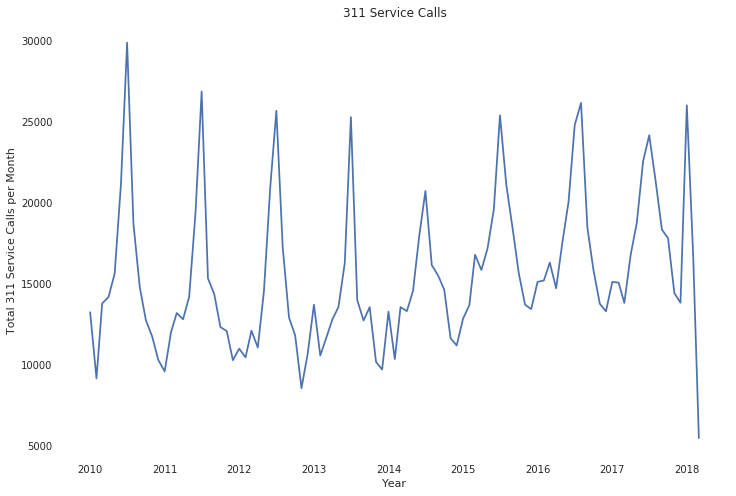

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.set_facecolor('white')
ax.grid(True)
plt.title("311 Service Calls")
plt.xlabel("Year")
plt.ylabel("Total 311 Service Calls per Month")
plt.plot(grouped_time["datetime"], grouped_time["unique_key"])

In [29]:
grouped_time.sort_values("datetime", inplace=True)

In [174]:
requests

,unique_key,created_date,closed_date,agency_acronym,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,city,status,due_date,resolution_date,community_board,borough,latitude,longitude
0,28272192,06/16/2014 09:34:00 AM,06/16/2014 12:00:00 PM,DSNY,BCC - Brooklyn South,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11232,218 31 STREET,31 STREET,BROOKLYN,Closed,NaN,06/16/2014 12:00:00 PM,07 BROOKLYN,BROOKLYN,40.656066,-73.999805
1,28272281,06/16/2014 08:21:00 AM,06/16/2014 12:00:00 PM,DSNY,BCC - Brooklyn South,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11234,5207 AVENUE T,AVENUE T,BROOKLYN,Closed,NaN,06/16/2014 12:00:00 PM,18 BROOKLYN,BROOKLYN,40.611781,-73.923889
2,28272228,06/16/2014 12:00:00 AM,07/15/2014 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,1-2 Family Dwelling,11209,230 94 STREET,94 STREET,BROOKLYN,Closed,07/16/2014 12:13:55 PM,07/15/2014 12:00:00 AM,10 BROOKLYN,BROOKLYN,40.618345,-74.034990
3,28272229,06/16/2014 12:00:00 AM,07/01/2014 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11215,NaN,NaN,BROOKLYN,Closed,07/16/2014 02:30:53 PM,07/01/2014 12:00:00 AM,06 BROOKLYN,BROOKLYN,40.662800,-73.978348
4,28272230,06/16/2014 12:00:00 AM,04/28/2014 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Commercial Building,10002,174 ORCHARD STREET,ORCHARD STREET,NEW YORK,Pending,07/16/2014 11:05:03 PM,04/28/2014 12:00:00 AM,03 MANHATTAN,MANHATTAN,40.721688,-73.988391
5,28272232,06/16/2014 06:59:00 AM,06/18/2014 12:00:00 PM,DSNY,BCC - Brooklyn North,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11221,WOODBINE STREET,WOODBINE STREET,BROOKLYN,Closed,NaN,06/18/2014 12:00:00 PM,04 BROOKLYN,BROOKLYN,40.690767,-73.918473
6,28272233,06/16/2014 10:31:00 AM,06/20/2014 12:00:00 PM,DSNY,BCC - Brooklyn North,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11201,76 WILLOUGHBY STREET,WILLOUGHBY STREET,BROOKLYN,Closed,NaN,06/20/2014 12:00:00 PM,02 BROOKLYN,BROOKLYN,40.692167,-73.985745
7,28272234,06/16/2014 06:48:00 PM,06/17/2014 12:00:00 PM,DSNY,Queens East 10,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11420,NaN,NaN,South Ozone Park,Closed,NaN,06/17/2014 12:00:00 PM,10 QUEENS,QUEENS,40.667899,-73.816844
8,28272236,06/16/2014 12:00:00 AM,06/20/2014 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,1-2 Family Dwelling,11436,116-21 148 STREET,148 STREET,Jamaica,Closed,07/16/2014 09:55:26 AM,06/20/2014 12:00:00 AM,12 QUEENS,QUEENS,40.681772,-73.793457
9,28272257,06/16/2014 03:05:51 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,556 DRIGGS AVENUE,DRIGGS AVENUE,BROOKLYN,Open,07/31/2014 03:05:51 PM,06/17/2014 04:27:21 PM,01 BROOKLYN,BROOKLYN,40.716921,-73.956571


In [181]:
nta_requests.iloc[50:100]

,nta_code,unique_key,geometry,nta_name,population,calls_fraction
50,BX05,8904,"POLYGON ((-73.88362659930451 40.8672658789162,...",Bedford Park-Fordham North,54415,0.163631
51,BX06,4795,"POLYGON ((-73.8830952421818 40.8666104758242, ...",Belmont,27378,0.175141
52,BX07,5191,"POLYGON ((-73.86138065247829 40.8713448046274,...",Bronxdale,35538,0.146069
53,BX08,5494,"POLYGON ((-73.8627241438726 40.8329289679362, ...",West Farms-Bronx River,35011,0.156922
54,BX09,473,"POLYGON ((-73.88054726659371 40.8184763038435,...",Soundview-Castle Hill-Clason Point-Harding Park,53686,0.008810
55,BX13,3343,POLYGON ((-73.82027572895541 40.88555899702811...,Co-Op City,43752,0.076408
56,BX14,9609,POLYGON ((-73.90958869820309 40.84276466023171...,East Concourse-Concourse Village,62284,0.154277
57,BX17,7010,"POLYGON ((-73.8831212430506 40.8482293795886, ...",East Tremont,43423,0.161435
58,BX22,3392,"POLYGON ((-73.89663476350309 40.9114256744216,...",North Riverdale-Fieldston-Riverdale,27860,0.121752
59,BX26,7921,"POLYGON ((-73.9172886216287 40.8451123715614, ...",Highbridge,37727,0.209956


In [71]:
gentrified = {"BK81", "BK82", "BK85", "BK93", "BX01", "BX05", "BX07", "BX08", "BX14", "BX27", "BX28", "BX30", "BX33", "BX34", "BX35", "BX40", "BX43", "BX44", "BX59", "BX63", "MN01", "MN06", "MN34", "MN35", "QN61" }

In [ ]:
nta_with_demographics.plot(ax=ax, edgecolor='black', column='people_per_acre', cmap='Greens')

In [56]:
lala = nta_with_demographics.copy()

In [55]:
nta[nta["nta_code"] == "BX40"]

,nta_code,geometry,nta_name,population
106,BX40,"POLYGON ((-73.89138165462259 40.8617088778157,...",Fordham South,28262


In [74]:
lala["gentrified"] = gentrified_ordered

In [ ]:
lala.iteritems

In [72]:
gentrified_ordered = []
for item in lala["nta_code"]:
    if item in gentrified:
        gentrified_ordered.append(1)
    else:
        gentrified_ordered.append(0)

In [75]:
lala[lala["nta_code"] == "QN61"]

,nta_code,unique_key,geometry,nta_name_x,population_x,calls_fraction,nta_name_y,borough,population_y,under_5_years,...,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income,gentrified
151,QN61,13059,"POLYGON ((-73.7684468367285 40.7096452912339, ...",Jamaica,53751,0.242954,Jamaica,Queens,53751,3818,...,2023,2647,2995,1363,1223,574,276,39763,53129,1


/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


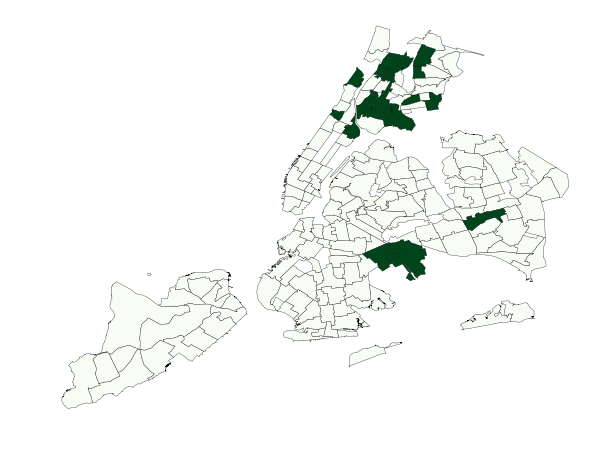

In [76]:
fig, ax = plt.subplots()
plt.axis("off")
fig.set_size_inches(10,15)
ax.set_facecolor('grey')
ax.grid(False)
ax.set_aspect('equal')
lala.plot(ax=ax, edgecolor='black', column='gentrified', cmap='Greens')